In [291]:
#!pip install yfinance
#!pip install pytickersymbols

In [292]:
import os
import requests 
from io import StringIO
import yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pytickersymbols import PyTickerSymbols
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from time import sleep

In [293]:
sp400_url="https://en.wikipedia.org/wiki/List_of_S%26P_400_companies"
sp400, *_=pd.read_html(sp400_url)
sp400 = sp400['Ticker symbol'].to_list()

# sp500_url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# sp500, *_=pd.read_html(sp500_url)

# sp600_url="https://en.wikipedia.org/wiki/List_of_S%26P_600_companies"
# sp600, *_=pd.read_html(sp600_url)

In [294]:
stock_data = PyTickerSymbols()

nasdaq_100=pd.DataFrame(stock_data.get_stocks_by_index('NASDAQ 100'))
nasdaq_100 = nasdaq_100[nasdaq_100.symbol != 'CTRP'].reset_index().symbol.to_list()

sp_500=pd.DataFrame(stock_data.get_stocks_by_index('S&P 500'))
sp_500 = sp_500[sp_500.symbol != 'SSE']
sp_500 = sp_500[sp_500.symbol != 'RTN']
sp_500 = sp_500[sp_500.symbol != 'CXO']
sp_500 = sp_500[sp_500.symbol != 'JEC']
sp_500 = sp_500[sp_500.symbol != 'SPY']
sp_500 = sp_500[sp_500.symbol != 'TIF'].reset_index().symbol.to_list()

stocks = nasdaq_100 + sp_500 #+ sp400

stocks = set(stocks) #Convierte la lista a Set, que lo único que hace es quitar elementos repetidos
stocks = list(stocks) #Reconvertir el set a list (para poder iterar sobre ella)

In [295]:
# import random 
# stocks = random.sample(stocks, 50)

In [296]:
len(stocks)

514

In [297]:
tol = 0 #Porcentaje máximo de tolerancia para el second bar
risk = [2] #R's a los que se tomaría target 
#risk = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]
porcentaje = [.01]
#porcentaje = [.01, .02, .03, .01, .02, .03, .01, .02, .03, .01, .02, .03] #Porcentaje de movimiento de la Igniting Bar

porcentaje_gap = .01

# data = yfinance.download(stocks, period='60d', interval='15m')[['Low', 'High', 'Open', 'Close']]
# data_day = yfinance.download(stocks, period='60d')[['Low', 'High']]

In [298]:
#Obtener cantidad de periodos (candles) en un día
periods = yfinance.download('SPY', period='1d', interval='5m')[['Low', 'High', 'Open', 'Close']]

#Obtener los trading hours solamente
trading_hours = []
for i in range(len(periods.index)):
  trading_hours.append(periods.index[i].strftime('%H:%M:%S'))

slices = ['year1month1','year1month2','year1month3','year1month4','year1month5','year1month6',
          'year1month7','year1month8','year1month9','year1month10','year1month11','year1month12']

[*********************100%***********************]  1 of 1 completed


In [299]:
indices_iteracion = ['Risk', '% Igniting Bar']
iteracion = pd.DataFrame(indices_iteracion, index=indices_iteracion).drop(columns=0)

indices_totales = ['Igniting', 'Trigger', 'Stopped', 'Red', 'Green', 'Target', 'Total PL','PL/Trade']
totales = pd.DataFrame(indices_totales, index= indices_totales).drop(columns=0)

In [300]:
os.environ["ALPHA_VANTAGE_KEY"]="OHBFZ29FSIDE55IN"
key=os.environ["ALPHA_VANTAGE_KEY"]
alphav_url="https://www.alphavantage.co/query"

In [ ]:
#%%time
df_plot = pd.DataFrame()
for p in tqdm(range(len(risk))):
  resultados = ['Igniting', 'Trigger', 'Stopped', 'Red', 'Green', 'Total PL','PL/Trade'] # 'Target',
  total_por_stock = pd.DataFrame(resultados, index=resultados)
  total_por_stock = pd.DataFrame.copy(total_por_stock.drop(columns=0))
  
  for t in tqdm(range(len(stocks))):
    #OPCION PARA DATOS CON YFINANCE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    data = yfinance.download(stocks[t], period='60d', interval='5m')[['Open', 'High', 'Low', 'Close']]
    data_day = yfinance.download(stocks[t], period='60d')[['Low', 'High']]
    
    data['Ticker'] = stocks[t]
    data['Gap'] = np.nan
    data['Igniting Bar'] = np.nan 
    data['Trigger'] = np.nan 
    data['Stopped'] = np.nan
    data['Red'] = np.nan 
    data['Green'] = np.nan 
    #data['Target'] = np.nan 
    data['Entry_Pr'] = np.nan
    data['Stop_Pr'] = np.nan
    data['Target_Pr'] = np.nan 
    
    PL_total = 0
    for i in range(1,len(data)-2): 
      gap = (data['Open'][i] - data['Close'][i-1]) / data['Close'][i-1]
      data['Gap'][i] = gap
      #Condición principal: Que sea al inicio del día (9:30)
      #VERSION PARA LONG TRADE:::::::::::::::::::::::::::::: #se agrega condicion para que sean los mismos periodos en cada stock (intra y daily)
      if (gap >= 0 and data.index[i].strftime('%H:%M:%S') == '09:30:00' and len(data) <= (len(periods)*60) and len(data_day) == 60
          and len(data.loc[data.index[i].strftime('%Y-%m-%d')]) == len(periods)): #and gap < porcentaje_gap and gap > 0): 
        long_bar_percentage = (data['High'][i] - data['Low'][i])/data['Low'][i]
        #CONDICIONES PARA QUE EL "IGNITING" BAR SEA CANDIDATO: 
        #  2)... Que el movimiento sea mayor o igual al porcentaje específicado en la barra
        # 3)... Que el Igniting sea barra verde (close arriba del open) 4)...Que el Close de la barra sea mas alto que el High del día previo (mas potencia)
        # 5)...Close de la barra siguiente sea menor al High del "Igniting" Bar 6)... Que el Low segundo bar esté por arriba de una cuarta parte del Igniting
        if (data['Close'][i] > data['Open'][i] #and long_bar_percentage >= porcentaje[p]  
            and data['Close'][i] > data_day['High'].loc[data.index[i-1].strftime('%Y-%m-%d')] and data['High'][i]*(1+tol) >= data['High'][i+1] 
            and (((data['High'][i] - data['Low'][i])/2) + data['Low'][i]) < data['Low'][i+1]):
          data['Igniting Bar'][i] = long_bar_percentage
  
        entry = 0
        stop = 0
        target = 0
        #Loop para definir si se entra al trade, y se definen stops, entries y targets
        if data['Igniting Bar'][i] > 0:
          for k in range(i+2, i+len(periods)-1):
            if data['High'][k] > data['High'][i]:
              data['Trigger'][i] = True

              entry = data['High'][i] + .01
              data['Entry_Pr'][i] = entry
              stop = entry - (data['Low'][i+1] - .01)
              data['Stop_Pr'][i] = data['Low'][i+1] -.01
              target = entry + (stop*risk[p])
              data['Target_Pr'][i] = target
              break
  
      #Se define si el trade toca el stop, target o si termina en green o red al final del día
        pl = 0
        if data['Trigger'][i] == True: #and i+len(periods) == len(data):
          for j in range(k, i+len(periods)):
            pl = (data['Close'][j] - entry) / (entry - data['Low'][i+1])
            if pl <= -1:
              data['Stopped'][i] = -1
            elif pl < 0:
              data['Red'][i] = pl
            elif pl >= 0:
              data['Green'][i] = pl
            
            # if data['Low'][j] <= (data['Low'][i+1] - .01):
            #   data['Stopped'][i] = -1
            #   break
            # elif j == (i+len(periods)-1):
            #   pl = (data['Close'][j] - entry) / (entry - data['Low'][i+1])
            #   if pl < 0: 
            #     data['Red'][i] = pl
            #   else: 
            #     data['Green'][i] = pl

      #Condición principal: Que sea al inicio del día (9:30)
      #VERSION PARA SHORT TRADE:::::::::::::::::::::::::::::: #se agrega condicion para que sean los mismos periodos en cada stock (intra y daily)
      elif (gap < 0 and data.index[i].strftime('%H:%M:%S') == '09:30:00' and len(data) <= (len(periods)*60) and len(data_day) == 60
            and len(data.loc[data.index[i].strftime('%Y-%m-%d')]) == len(periods)): #gap > -porcentaje_gap and gap < 0 and 
        long_bar_percentage = (data['Low'][i] - data['High'][i])/data['High'][i]
        #CONDICIONES PARA QUE EL "IGNITING" BAR SEA CANDIDATO: 
        #2)... Que el movimiento sea menor o igual a -porcentaje en la Igniting bar
        #3)... Que el Igniting sea barra roja (close abajo del open) 4)...Que el Close de la barra sea mas bajo que el Low del día previo (mas potencia)
        #5)...Close de la barra siguiente sea mayor al Low del "Igniting" Bar 6)... Que el High segundo bar esté por arriba de una cuarta parte del Igniting
        if (data['Close'][i] < data['Open'][i] #and long_bar_percentage <= -porcentaje[p]
          and data['Close'][i] < data_day['Low'].loc[data.index[i-1].strftime('%Y-%m-%d')] and data['Low'][i]*(1+tol) <= data['Low'][i+1] 
          and ((data['High'][i] - (data['High'][i] - data['Low'][i])/2)) > data['High'][i+1]):
          data['Igniting Bar'][i] = long_bar_percentage
    
        entry = 0
        stop = 0
        target = 0
        #Loop para definir si se entra al trade, y se definen stops, entries y targets
        if data['Igniting Bar'][i] < 0:
          for k in range(i+2, i+len(periods)-1):
            if data['Low'][k] < data['Low'][i]:
              data['Trigger'][i] = True

              entry = data['Low'][i] - .01
              data['Entry_Pr'][i] = entry
              stop = (data['High'][i+1] + .01) - entry
              data['Stop_Pr'][i] = data['High'][i+1] +.01
              target = entry - (stop*risk[p])
              data['Target_Pr'][i] = target
              break
    
        #Se define si el trade toca el stop, target o si termina en green o red al final del día
        pl = 0
        if data['Trigger'][i] == True: #and i+len(periods) == len(data):
          for j in range(k, i+len(periods)):
            pl = (entry - data['Close'][j]) / ((data['High'][i+1] + .01) - entry)
            if pl <= -1:
              data['Stopped'][i] = -1
            elif pl < 0:
              data['Red'][i] = pl
            elif pl >= 0:
              data['Green'][i] = pl

            # if data['High'][j] >= (data['High'][i+1] +.01): #i+len(periods) == len(data) and
            #   data['Stopped'][i] = -1
            #   break
            # elif j == (i+len(periods)-1):
            #   pl = (entry - data['Close'][j]) / ((data['High'][i+1] + .01) - entry)
            #   if pl < 0: 
            #     data['Red'][i] = pl
            #   else: 
            #     data['Green'][i] = pl

    df_plot = pd.concat([df_plot,data])
    total_por_stock.insert(t, stocks[t], [data['Igniting Bar'].count(), data['Trigger'].count(), data['Stopped'].count(), data['Red'].count(),
                                            data['Green'].count(), PL_total, PL_total/data['Trigger'].count()])  #data['Target'].count(),

  iteracion.insert(p,p, [risk[p], porcentaje[p]])
  total_por_stock['sum'] = total_por_stock.sum(axis=1)

  totales.insert(p, p, [total_por_stock['sum'][0], total_por_stock['sum'][1], (total_por_stock['sum'][2]/total_por_stock['sum'][1]),
                        (total_por_stock['sum'][3]/total_por_stock['sum'][1]), (total_por_stock['sum'][4]/total_por_stock['sum'][1]),
                        (total_por_stock['sum'][5]/total_por_stock['sum'][1]), total_por_stock['sum'][6],
                        (total_por_stock['sum'][6]/total_por_stock['sum'][1])])

In [303]:
riesgo = 3

completo = df_plot[(df_plot.index.strftime('%H:%M:%S') == '09:30:00') & (df_plot['Trigger'] == 1)]

for i in range(len(completo)):
  if completo['Green'][i] >= riesgo:
    completo['Green'][i] = riesgo

opcion1 = completo[((completo['Gap'] > 0) & (completo['Gap'] < .005) & (completo['Igniting Bar'] > 0.01))]

print(f'CON UN RIESGO DE {riesgo}')
print(f'Total de Trades: {len(opcion1)}, Trades por día: {len(opcion1)/60:,.2f}')
print(f'Porcentaje de Losers: {opcion1.Stopped.count()/len(opcion1):,.3f}, con R total de: {opcion1.Stopped.sum()}')
print(f'Porcentaje de Reds: {opcion1.Red.count()/len(opcion1):,.3f}, con R total de: {opcion1.Red.sum():,.2f}')
print(f'Porcentaje de Greens: {opcion1.Green[(opcion1.Green < riesgo) & (opcion1.Green > 0)].count()/len(opcion1):,.3f}, con R total de: {opcion1.Green[(opcion1.Green < riesgo) & (opcion1.Green > 0)].sum():,.2f}')
print(f'Porcentaje de Targets: {opcion1.Green[opcion1.Green == riesgo].count()/len(opcion1):,.3f}, con R total de: {opcion1.Green[opcion1.Green == riesgo].sum()}')
print(f'TOTAL DE Rs en el periodo: {opcion1.Stopped.sum() + opcion1.Red.sum() + opcion1.Green.sum():,.3f}')
print(f'R/Trade: {(opcion1.Stopped.sum() + opcion1.Red.sum() + opcion1.Green.sum())/len(opcion1):,.3f}')
#opcion1.head(20)

CON UN RIESGO DE 3
Total de Trades: 39, Trades por día: 0.65
Porcentaje de Losers: 0.538, con R total de: -21.0
Porcentaje de Reds: 0.872, con R total de: -15.38
Porcentaje de Greens: 0.897, con R total de: 27.82
Porcentaje de Targets: 0.077, con R total de: 9.0
TOTAL DE Rs en el periodo: 0.439
R/Trade: 0.011


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [304]:
riesgo = 2

completo = df_plot[(df_plot.index.strftime('%H:%M:%S') == '09:30:00') & (df_plot['Trigger'] == 1)]

for i in range(len(completo)):
  if completo['Green'][i] >= riesgo:
    completo['Green'][i] = riesgo

opcion1 = completo[((completo['Gap'] > 0) & (completo['Gap'] < .005) & (completo['Igniting Bar'] > 0.01))]

print(f'CON UN RIESGO DE {riesgo}')
print(f'Total de Trades: {len(opcion1)}, Trades por día: {len(opcion1)/60:,.2f}')
print(f'Porcentaje de Losers: {opcion1.Stopped.count()/len(opcion1):,.3f}, con R total de: {opcion1.Stopped.sum()}')
print(f'Porcentaje de Reds: {opcion1.Red.count()/len(opcion1):,.3f}, con R total de: {opcion1.Red.sum():,.2f}')
print(f'Porcentaje de Greens: {opcion1.Green[(opcion1.Green < riesgo) & (opcion1.Green > 0)].count()/len(opcion1):,.3f}, con R total de: {opcion1.Green[(opcion1.Green < riesgo) & (opcion1.Green > 0)].sum():,.2f}')
print(f'Porcentaje de Targets: {opcion1.Green[opcion1.Green == riesgo].count()/len(opcion1):,.3f}, con R total de: {opcion1.Green[opcion1.Green == riesgo].sum()}')
print(f'TOTAL DE Rs en el periodo: {opcion1.Stopped.sum() + opcion1.Red.sum() + opcion1.Green.sum():,.3f}')
print(f'R/Trade: {(opcion1.Stopped.sum() + opcion1.Red.sum() + opcion1.Green.sum())/len(opcion1):,.3f}')
#opcion1.head(20)

CON UN RIESGO DE 2
Total de Trades: 39, Trades por día: 0.65
Porcentaje de Losers: 0.538, con R total de: -21.0
Porcentaje de Reds: 0.872, con R total de: -15.38
Porcentaje de Greens: 0.821, con R total de: 20.74
Porcentaje de Targets: 0.154, con R total de: 12.0
TOTAL DE Rs en el periodo: -3.644
R/Trade: -0.093


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [305]:
riesgo = 1

completo = df_plot[(df_plot.index.strftime('%H:%M:%S') == '09:30:00') & (df_plot['Trigger'] == 1)]

for i in range(len(completo)):
  if completo['Green'][i] >= riesgo:
    completo['Green'][i] = riesgo

opcion1 = completo[((completo['Gap'] > 0) & (completo['Gap'] < .005) & (completo['Igniting Bar'] > 0.01))]

print(f'CON UN RIESGO DE {riesgo}')
print(f'Total de Trades: {len(opcion1)}, Trades por día: {len(opcion1)/60:,.2f}')
print(f'Porcentaje de Losers: {opcion1.Stopped.count()/len(opcion1):,.3f}, con R total de: {opcion1.Stopped.sum()}')
print(f'Porcentaje de Reds: {opcion1.Red.count()/len(opcion1):,.3f}, con R total de: {opcion1.Red.sum():,.2f}')
print(f'Porcentaje de Greens: {opcion1.Green[(opcion1.Green < riesgo) & (opcion1.Green > 0)].count()/len(opcion1):,.3f}, con R total de: {opcion1.Green[(opcion1.Green < riesgo) & (opcion1.Green > 0)].sum():,.2f}')
print(f'Porcentaje de Targets: {opcion1.Green[opcion1.Green == riesgo].count()/len(opcion1):,.3f}, con R total de: {opcion1.Green[opcion1.Green == riesgo].sum()}')
print(f'TOTAL DE Rs en el periodo: {opcion1.Stopped.sum() + opcion1.Red.sum() + opcion1.Green.sum():,.3f}')
print(f'R/Trade: {(opcion1.Stopped.sum() + opcion1.Red.sum() + opcion1.Green.sum())/len(opcion1):,.3f}')
#opcion1.head(20)

CON UN RIESGO DE 1
Total de Trades: 39, Trades por día: 0.65
Porcentaje de Losers: 0.538, con R total de: -21.0
Porcentaje de Reds: 0.872, con R total de: -15.38
Porcentaje de Greens: 0.615, con R total de: 8.49
Porcentaje de Targets: 0.359, con R total de: 14.0
TOTAL DE Rs en el periodo: -13.889
R/Trade: -0.356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


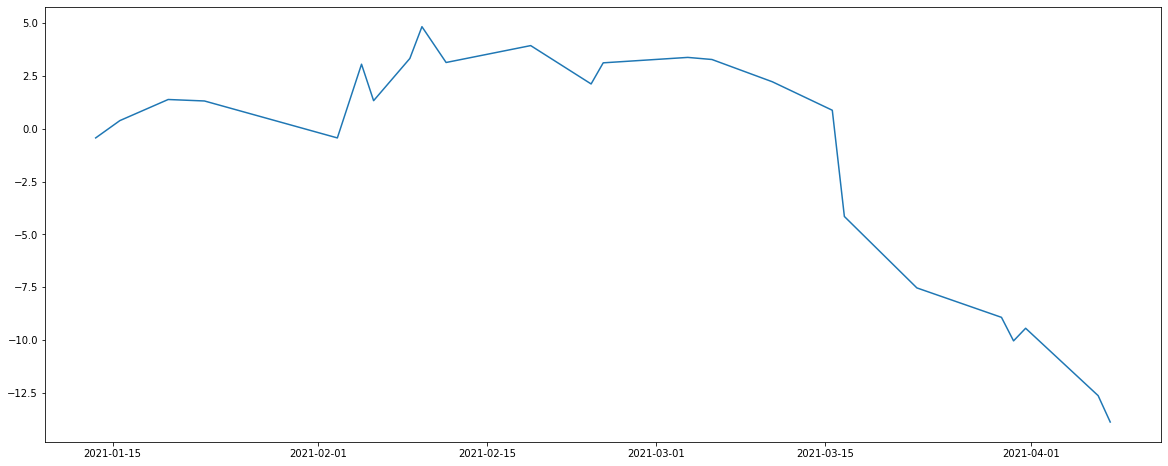

In [306]:
#PLOTEAR PARA REVISAR LA DISTRIBUCION DE LOS TRADES EN EL TIEMPO ANALIZADO

df_distribution = opcion1.fillna(value=0)
df_distribution['PL'] = df_distribution['Green'] + df_distribution['Red'] + df_distribution['Stopped']
plt.figure(figsize=(20,8))
plt.plot(df_distribution.groupby(df_distribution.index).agg({'PL':sum}).cumsum())

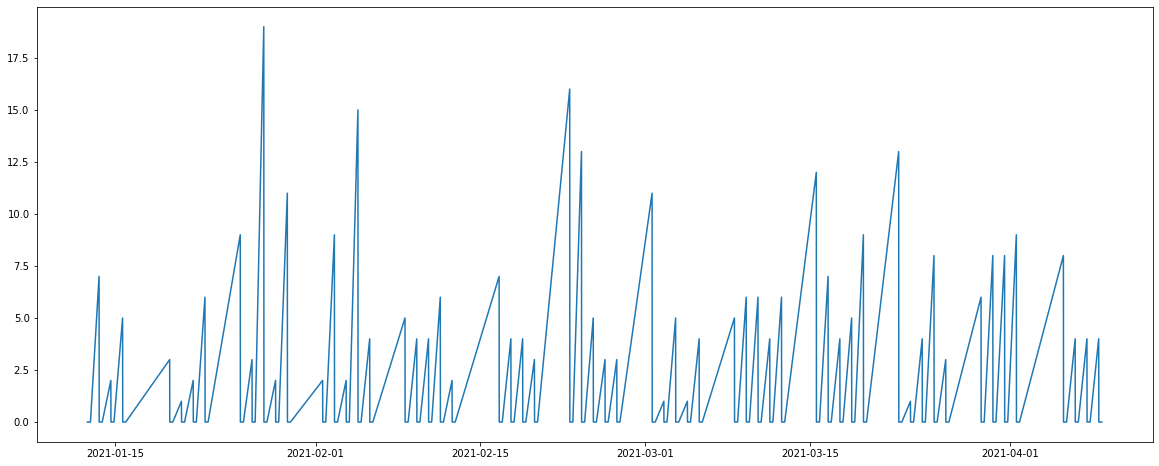

In [307]:
#TRADES POR DÍA
plt.figure(figsize=(20,8))
plt.plot(df_plot.groupby(df_plot.index).agg({'Trigger':sum}))

In [308]:
#df_distribution.groupby(df_distribution.index).agg({'Trigger':sum})

In [309]:
#Profitability del Backtesting, definiendo el R (comision standard)

R = 25 #dolares por trade
comision = 3 #1.5 por abrir y cerrar

(totales.loc['Total PL'] * R) - (totales.loc['Trigger'] * comision)

0   -1041.0
dtype: float64